# Total: 75-91

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz75_91_newnames.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_75to91']
X = df.loc[:, ~df.columns.isin(['std_inz_75to91', 'eastwest'])]
print("Number of features: ", len(X.columns))

Number of features:  163


# Feature Correlation

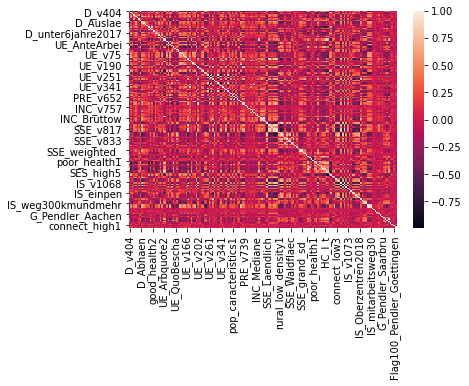

In [4]:
corr = X.corr()
sns.heatmap(corr)

In [5]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

Index(['D_v404', 'D_Abhaen'], dtype='object') 0.9524120276596159
Index(['D_Lebens', 'good_health2'], dtype='object') 0.9204456724863157
Index(['UE_Arbquote2', 'SES_high10'], dtype='object') 0.9119272462198496
Index(['UE_Arbquote2', 'SES_high5'], dtype='object') 0.9463415538519439
Index(['UE_Erwerb', 'SSE_v967'], dtype='object') 0.954018824286417
Index(['UE_v190', 'PRE_v727'], dtype='object') 0.9155820449459651
Index(['UE_v202', 'PRE_v733'], dtype='object') 0.9306349457201186
Index(['UE_v251', 'UE_v323'], dtype='object') 0.9254118518258707
Index(['UE_v261', 'UE_v341'], dtype='object') 0.985915660196274
Index(['UE_v323', 'UE_v381'], dtype='object') 0.9230275788292607
Index(['PRE_v733', 'PRE_v739'], dtype='object') 0.9508453295146841
Index(['INC_Bruttow', 'INC_v1175'], dtype='object') 0.9999935949643353
Index(['SSE_Laendlich', 'SSE_Freiflaec'], dtype='object') 0.9026580911230444
Index(['SSE_v817', 'SSE_AnteilErh'], dtype='object') 0.9117060576457896
Index(['SSE_weighted_', 'SSE_grand_sd_'

# First CatBoost Model with 162 features

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of second model with top20 feature: ",cb.score(X, Y))

R2 of second model with top20 feature:  0.99941318226255


In [7]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  1.5513880780312173


# SHAP VAlues

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


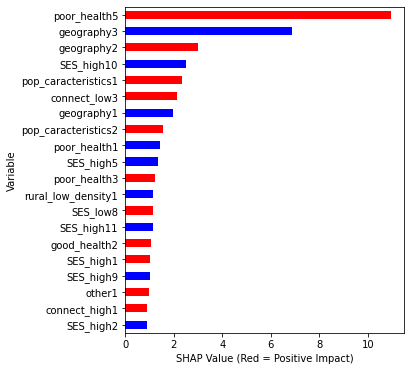

In [9]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

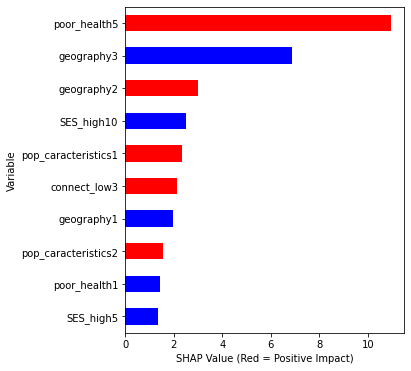

In [10]:
def ABS_SHAP_10(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-10::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP_10(shap_values_cb,X) 

# Second CatBoost model with 20 most important features

In [11]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [12]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of final model on all data: ",cb_20.score(X[top20feature], Y))

R2 of final model on all data:  0.9968733955612183


In [13]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  3.581008100853761


# Compare top 10 features of both Models

In [14]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['poor_health5', 'geography3', 'geography2', 'SES_high10', 'pop_caracteristics1', 'connect_low3', 'geography1', 'pop_caracteristics2', 'poor_health1', 'SES_high5'] 

 10 most important features from model with top20 features: 
 ['poor_health5', 'pop_caracteristics1', 'geography1', 'rural_low_density1', 'geography3', 'poor_health1', 'geography2', 'SES_high1', 'SES_high10', 'poor_health3']


In [15]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

poor_health5
geography3
geography2
SES_high10
pop_caracteristics1
geography1
poor_health1


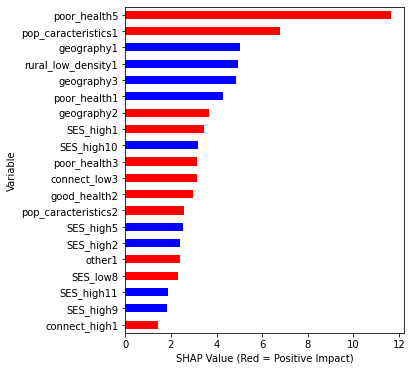

In [16]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

# Hold out validation of the second model

In [17]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [18]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9976910788947635
Mean R2 of linReg_modesl with top20 features:  0.5225118555682702
Mean RMSE of CatBoost_models on test sets with top20 features:  50.54659843873339
Mean R2 of CatBoost_models on test sets with top20 features: 0.4867417380496491


# descriptives of top20 features

In [19]:
X[top20feature].describe()

,poor_health5,geography3,geography2,SES_high10,pop_caracteristics1,connect_low3,geography1,pop_caracteristics2,poor_health1,SES_high5,poor_health3,rural_low_density1,SES_low8,SES_high11,good_health2,SES_high1,SES_high9,other1,connect_high1,SES_high2
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,7.706820,431.346405,9.866996,5.259102,32.242809,21.925186,50.615292,75.075867,50.857368,8.995763,24.358610,70.509460,13.988770,32.202751,23.700602,1591.685791,9.834411,1.632219,0.047382,9.687282
std,14.427098,187.236847,2.026269,2.706737,24.361435,15.378859,1.740311,3.794014,6.518343,4.146994,5.373881,56.734707,4.891640,8.077894,0.656121,589.468872,2.016845,0.134031,0.212719,2.725502
min,0.000000,56.052784,6.083333,1.400000,1.700000,0.000000,47.500000,63.099998,28.600000,2.200000,11.100000,14.000000,0.000000,10.500000,22.020000,2.000000,3.000000,1.060000,0.000000,3.700000
25%,2.452555,291.752441,8.216666,2.900000,7.900000,13.000000,49.283333,72.699997,46.400002,5.800000,20.400000,39.700001,10.600000,25.600000,23.270000,1591.000000,8.600000,1.560000,0.000000,7.700000
50%,5.019764,420.680756,9.766666,4.900000,29.100000,21.000000,50.549999,75.300003,51.099998,8.500000,23.700001,52.799999,13.900000,32.700001,23.680000,1764.000000,10.200000,1.650000,0.000000,9.400000
75%,9.171128,569.178772,11.416667,6.600000,52.299999,32.000000,51.849998,77.599998,55.599998,11.100000,27.500000,76.699997,16.900000,38.500000,24.180000,1904.000000,11.200000,1.720000,0.000000,11.000000
max,259.999207,866.911194,14.983334,16.500000,87.800003,79.000000,54.783333,84.099998,66.699997,23.799999,43.299999,384.600006,47.700001,53.400002,25.719999,2904.000000,14.800000,1.940000,1.000000,20.799999


In [20]:
pd.DataFrame(Y).describe()

,std_inz_75to91
count,401.000000
mean,79.461769
std,64.122574
min,2.714423
25%,40.307571
50%,63.813667
75%,99.633545
max,671.134949


In [21]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives2.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 2')